# Homework 2

## FINM 35700 - Spring 2025

### UChicago Financial Mathematics

### Due Date: 2025-04-08

* Matheus Raka Pradnyatama
* matheusraka@uchicago.edu

This homework relies on:

- the corporate and government bonds symbology file `bond_symbology`, 
- the "on-the-run" treasuries data file `govt_on_the_run`,
- the bond market data file `bond_market_prices_eod`, containing EOD price data as of 2024-12-13.

------------------------------------------------------------------------------------------
# Problem 1: Constructing fixed rate bonds

In [1]:
import pandas as pd
import numpy as np
import datetime
import holidays
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import QuantLib as ql
import datetime as dt
# The code is made with the help of OpenAI's ChatGPT.

# Use static calculation/valuation date of 2024-12-13, matching data available in the market prices EOD file
calc_date = ql.Date(13, 12, 2024)
ql.Settings.instance().evaluationDate = calc_date

## a. Prepare the symbology and market data files for fixed rate government and corporate bonds

Load the `bond_symbology`, `bond_market_prices_eod` and `govt_on_the_run` Excel files into dataframes. Filter the symbology frame for fixed rate bonds only (cpn_type="FIXED").


In [2]:
# Bond Symbology Dataframe = Containing both corporate and US Government Bonds

filepath_rawdata = f'./data/bond_symbology.xlsx'
symbology = pd.read_excel(filepath_rawdata)
 
symbology_fixed = symbology[(symbology['cpn_type'] == 'FIXED')]
display(symbology_fixed.head(3))

filepath_rawdata = f'./data/govt_on_the_run.xlsx'
df_govt = pd.read_excel(filepath_rawdata)
# r'[BC] Govt$' matches string that ends with B Govt or C Govt
# ~ negates the filter, showing rows that DO NOT match the filter (those that don't have BC)
df_ontherun = df_govt[~df_govt['ticker'].str.contains(r'[BC] Govt$', regex=True)]
display(df_ontherun.head(3))

# Dataframe of market prices
filepath_rawdata = f'./data/bond_market_prices_eod.xlsx'
df_market = pd.read_excel(filepath_rawdata)
display(df_market.head(3))

,ticker,class,figi,isin,und_bench_isin,security,name,type,coupon,cpn_type,...,start_date,cpn_first,acc_first,maturity,mty_typ,rank,amt_out,country,currency,status
0,AAPL,Corp,BBG004HST0K7,US037833AL42,US912810UF39,AAPL 3.85 05/04/43,APPLE INC,GLOBAL,3.85,FIXED,...,2013-05-03,2013-11-04,2013-05-03,2043-05-04,AT MATURITY,Sr Unsecured,3000.0,US,USD,ACTV
1,AAPL,Corp,BBG006F8VWJ7,US037833AT77,US912810UF39,AAPL 4.45 05/06/44,APPLE INC,GLOBAL,4.45,FIXED,...,2014-05-06,2014-11-06,2014-05-06,2044-05-06,AT MATURITY,Sr Unsecured,1000.0,US,USD,ACTV
2,AAPL,Corp,BBG0081TNL50,US037833BA77,US912810UF39,AAPL 3.45 02/09/45,APPLE INC,GLOBAL,3.45,FIXED,...,2015-02-09,2015-08-09,2015-02-09,2045-02-09,AT MATURITY,Sr Unsecured,2000.0,US,USD,ACTV


,ticker,date,figi,isin
0,GT10 Govt,2024-12-13,BBG01QKHSMP5,US91282CLW90
3,GT2 Govt,2024-12-13,BBG01QZFYJV6,US91282CLY56
4,GT20 Govt,2024-12-13,BBG01QVTC1Y0,US912810UF39


,date,class,ticker,isin,figi,bidPrice,askPrice,accrued,bidYield,askYield
0,2024-12-13,Corp,AAPL,US037833BX70,BBG00C7QBG91,93.228,93.809,1.4595,5.180,5.132
1,2024-12-13,Corp,AAPL,US037833EK23,BBG011ZS1X57,63.723,64.232,0.9835,5.242,5.194
2,2024-12-13,Corp,AAPL,US037833DW79,BBG00TN2PN26,63.716,64.215,0.2585,5.253,5.205


## b. Add a function to construct generic fixed rate cashflow schedules from symbology data

Use one row of the symbology dataframe as input  to the function. Use the helper function to convert a date string to a QuantLib date object.

In [3]:
def get_ql_date(date) -> ql.Date:
    """
    convert dt.date to ql.Date
    """
    if isinstance(date, dt.date):
        return ql.Date(date.day, date.month, date.year)
    elif isinstance(date, str):
        date = dt.datetime.strptime(date, "%Y-%m-%d").date()
        return ql.Date(date.day, date.month, date.year)
    else:
        raise ValueError(f"to_qldate, {type(date)}, {date}")

### Example Usage

In [4]:
example_date_1 = get_ql_date("2025-04-05")  # ql.Date(5, 4, 2025)
print(example_date_1)

example_date_2 = get_ql_date(dt.date(2026, 6, 10))  # ql.Date(10, 6, 2026)
print(example_date_2)

April 5th, 2025
June 10th, 2026


In [5]:
def create_schedule_from_symbology(details: dict):
    '''Create a QuantLib cashflow schedule from symbology details dictionary (usually one row of the symbology dataframe)
    '''
    # Create maturity from details['maturity']
    # maturity = ql.Date()    # use date helper function and update code !!!
    maturity = get_ql_date(details['maturity'])
    
    # Create acc_first from details['acc_first']
    #acc_first = ql.Date()   # use date helper function and update code !!!
    acc_first = get_ql_date(details['acc_first'])
    
    # Create calendar for Corp and Govt asset classes
    calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
    
    # define period from details['cpn_freq'] ... can be hard-coded to 2 = semi-annual frequency
    # period = ql.Period(2) 
    freq_map = {
    1: ql.Annual,
    2: ql.Semiannual,
    4: ql.Quarterly,
    12: ql.Monthly
    }
    period = ql.Period(freq_map[details['cpn_freq']])

    # business_day_convention
    business_day_convention = ql.Unadjusted
    
    # termination_date_convention
    termination_date_convention = ql.Unadjusted
    
    # date_generation
    date_generation=ql.DateGeneration.Backward
    
    # Create schedule using ql.MakeSchedule interface (with keyword arguments)
    schedule = ql.MakeSchedule(effectiveDate=acc_first,  # this may not be the same as the bond's start date
                            terminationDate=maturity,
                            tenor=period,
                            calendar=calendar,
                            convention=business_day_convention,
                            terminalDateConvention=termination_date_convention,
                            rule=date_generation,
                            endOfMonth=True,
                            firstDate=ql.Date(),
                            nextToLastDate=ql.Date())
    return schedule

In [6]:
# One row from the Symbology Dataframe
first_row = symbology_fixed.iloc[0]

# QuantLib Schedule object
schedule_symbology = create_schedule_from_symbology(first_row)
print(schedule_symbology)

# Printing the dates in the schedule
for d in schedule_symbology:
    print(d)

<QuantLib.QuantLib.Schedule; proxy of <Swig Object of type 'Schedule *' at 0x13e014300> >
May 3rd, 2013
May 4th, 2013
November 4th, 2013
May 4th, 2014
November 4th, 2014
May 4th, 2015
November 4th, 2015
May 4th, 2016
November 4th, 2016
May 4th, 2017
November 4th, 2017
May 4th, 2018
November 4th, 2018
May 4th, 2019
November 4th, 2019
May 4th, 2020
November 4th, 2020
May 4th, 2021
November 4th, 2021
May 4th, 2022
November 4th, 2022
May 4th, 2023
November 4th, 2023
May 4th, 2024
November 4th, 2024
May 4th, 2025
November 4th, 2025
May 4th, 2026
November 4th, 2026
May 4th, 2027
November 4th, 2027
May 4th, 2028
November 4th, 2028
May 4th, 2029
November 4th, 2029
May 4th, 2030
November 4th, 2030
May 4th, 2031
November 4th, 2031
May 4th, 2032
November 4th, 2032
May 4th, 2033
November 4th, 2033
May 4th, 2034
November 4th, 2034
May 4th, 2035
November 4th, 2035
May 4th, 2036
November 4th, 2036
May 4th, 2037
November 4th, 2037
May 4th, 2038
November 4th, 2038
May 4th, 2039
November 4th, 2039
May 4

## c. Add a function to construct generic fixed rate bond objects from symbology data

Implement the  create_schedule_from_symbology() function below. 

Identify and display the `AAPL 2.2 09/11/29` bond details in the symbology dataframe. Use create_schedule_from_symbology() to generate and display the cashflow schedule for `AAPL 2.2 09/11/29`.


In [7]:
def create_bond_from_symbology(details: dict):
    '''Create a US fixed rate bond object from symbology details dictionary (usually one row of the symbology dataframe)
    '''
    
     # Create day_count from details['dcc']
     # For US Treasuries use ql.ActualActual(ql.ActualActual.ISMA)
     # For US Corporate bonds use ql.Thirty360(ql.Thirty360.USA)
    # day_count = ql.Thirty360(ql.Thirty360.USA)   # update code depending on dcc !!!
    if details['dcc'] == 'ACT/ACT':
        day_count = ql.ActualActual(ql.ActualActual.ISMA)
    elif details['dcc'] == '30/360':
        day_count = ql.Thirty360(ql.Thirty360.USA)
    elif details['dcc'] == '30/360 NON-EOM':
        day_count = ql.Thirty360(ql.Thirty360.USA)
    elif details['dcc'] == "ACT/360":
        day_count = ql.Actual360()
    else:
        raise ValueError(f"Unsupported day count convention: {details['dcc']}")
    
    # Create day_count from details['start_date']    
    issue_date = get_ql_date(details['start_date'])
    
    # Create days_settle from details['days_settle']
    days_settle = int(details['days_settle'])
    
    # Create coupon from details['coupon']
    coupon = float(details['coupon']) / 100
    
    # Create cashflow schedule
    schedule = create_schedule_from_symbology(details)
    
    face_value = 100
    redemption = 100
    
    payment_convention = ql.Unadjusted
        
    # Create fixed rate bond object
    fixed_rate_bond = ql.FixedRateBond(
        days_settle,
        face_value,
        schedule,
        [coupon],
        day_count,
        payment_convention,
        redemption,
        issue_date)        

    return fixed_rate_bond


In [8]:
df_apple = symbology[(symbology['security'] == 'AAPL 2.2 09/11/29')]
df_apple

,ticker,class,figi,isin,und_bench_isin,security,name,type,coupon,cpn_type,...,start_date,cpn_first,acc_first,maturity,mty_typ,rank,amt_out,country,currency,status
18,AAPL,Corp,BBG00Q5L6G53,US037833DP29,US91282CMA61,AAPL 2.2 09/11/29,APPLE INC,GLOBAL,2.2,FIXED,...,2019-09-11,2020-03-11,2019-09-11,2029-09-11,CALLABLE,Sr Unsecured,1750.0,US,USD,ACTV


In [9]:
row_apple = symbology[(symbology['security'] == 'AAPL 2.2 09/11/29')].iloc[0] # This is a row

# QuantLib Schedule object
schedule_apple = create_schedule_from_symbology(row_apple)
print(schedule_apple)

name_apple = row_apple['security']

# Printing the cash flow dates in the schedule
print(f"Cash flow schedule: for {name_apple}")
for d in schedule_apple:
    print(d)

<QuantLib.QuantLib.Schedule; proxy of <Swig Object of type 'Schedule *' at 0x13e120510> >
Cash flow schedule: for AAPL 2.2 09/11/29
September 11th, 2019
March 11th, 2020
September 11th, 2020
March 11th, 2021
September 11th, 2021
March 11th, 2022
September 11th, 2022
March 11th, 2023
September 11th, 2023
March 11th, 2024
September 11th, 2024
March 11th, 2025
September 11th, 2025
March 11th, 2026
September 11th, 2026
March 11th, 2027
September 11th, 2027
March 11th, 2028
September 11th, 2028
March 11th, 2029
September 11th, 2029


## d. Add function that returns a dataframe with (future) cash flows details for a bond object

Use the "Investigate Bond Cashflows" section in the Quantlib introductory notebook as a template.

The results dataframe should contain following columns:


| CashFlowDate | CashFlowAmount | CashFlowYearFrac |
|----------|-------|-------------|

Create the bond objects and display the future cashflows for following securities:

* the `T 5 3/8 02/15/31` government bond and 
* the `AAPL 2.2 09/11/29` corporate bond.

In [10]:
def get_bond_cashflows(bond: ql.FixedRateBond, calc_date=ql.Date) -> pd.DataFrame:
    '''Returns all future cashflows as of calc_date, i.e. with payment dates > calc_date.
    takes the bond (in dictionary version) and date
    '''
    
    # all cash flows: 
    # x = [(cf.date(), cf.amount()) for cf in bond.cashflows()]

    # Future cash flows
    x = [(cf.date(), cf.amount()) for cf in bond.cashflows() if cf.date() > calc_date]
    cf_date_fixed, cf_amount = zip(*x)
     
    # create and display cashflows dataframe
    cashflows_df = pd.DataFrame(data={'CashFlowDate': cf_date_fixed, 'CashFlowAmount': cf_amount})
    
    # Adding column for year fraction
    cashflows_df["CashFlowYearFraction"] = cashflows_df.apply(lambda x: bond.dayCounter().yearFraction(calc_date, x["CashFlowDate"]), axis=1) 
    
    return cashflows_df

# Row from Symbology Dataframe
row_apple = symbology[(symbology['security'] == 'AAPL 2.2 09/11/29')].iloc[0]

# Today's Date
print(f"Today's date: {calc_date}")

# Security Name
name_apple = row_apple['security']
print(f"Security: {name_apple}")

# Cash Flow
bond_apple = create_bond_from_symbology(row_apple)
df_cashflow_apple = get_bond_cashflows(bond_apple, calc_date)
display(df_cashflow_apple)

Today's date: December 13th, 2024
Security: AAPL 2.2 09/11/29


,CashFlowDate,CashFlowAmount,CashFlowYearFraction
0,"March 11th, 2025",1.1,0.244444
1,"September 11th, 2025",1.1,0.744444
2,"March 11th, 2026",1.1,1.244444
3,"September 11th, 2026",1.1,1.744444
4,"March 11th, 2027",1.1,2.244444
5,"September 11th, 2027",1.1,2.744444
6,"March 11th, 2028",1.1,3.244444
7,"September 11th, 2028",1.1,3.744444
8,"March 11th, 2029",1.1,4.244444
9,"September 11th, 2029",1.1,4.744444


In [11]:
# T 5 3/8 02/15/31

# Row from Symbology Dataframe
row_treasury = symbology[(symbology['security'] == 'T 5 3/8 02/15/31')].iloc[0]
# print(row_treasury)

# Bond
bond_treasury = create_bond_from_symbology(row_treasury)
print(bond_treasury)

# Today's Date
print(f"Today's date: {calc_date}")

# Security Name
name_treasury = row_treasury['security']
print(f"Security: {name_treasury}")

# Cash Flow
df_cashflow_treasury = get_bond_cashflows(bond_treasury, calc_date)
display(df_cashflow_treasury)

<QuantLib.QuantLib.FixedRateBond; proxy of <Swig Object of type 'ext::shared_ptr< FixedRateBond > *' at 0x13e014570> >
Today's date: December 13th, 2024
Security: T 5 3/8 02/15/31


,CashFlowDate,CashFlowAmount,CashFlowYearFraction
0,"February 15th, 2025",2.6875,0.166667
1,"August 15th, 2025",2.6875,0.666667
2,"February 15th, 2026",2.6875,1.166667
3,"August 15th, 2026",2.6875,1.666667
4,"February 15th, 2027",2.6875,2.166667
5,"August 15th, 2027",2.6875,2.666667
6,"February 15th, 2028",2.6875,3.166667
7,"August 15th, 2028",2.6875,3.666667
8,"February 15th, 2029",2.6875,4.166667
9,"August 15th, 2029",2.6875,4.666667


------------------------------------------------------------------------------------------
# Problem 2: US Treasury yield curve calibration (On-The-Runs)

## a. Create the on-the-run US treasury bond objects

Restrict the symbology + market data dataframe to "on-the-run"/OTR US treasury notes/bonds only and create the treasury bond objects.

Extend the treasuries symbology dataframe with the following market data columns (code from Homework 1):


| date | bidPrice | askPrice | midPrice | bidYield | askYield | midYield | term | TTM |
|----------|-------|-------------|-----|----------|---------|---------|---------|---------|

Plot a graph/scatter plot of on-the-run treasury mid yields by TTM.

In [12]:
# Bond Symbology Dataframe = Containing both corporate and US Government Bonds
filepath_rawdata = f'./data/bond_symbology.xlsx'
bond_symbology = pd.read_excel(filepath_rawdata)
days_in_year = 365.25
date_today = pd.to_datetime('2024-12-13')
bond_symbology['term'] = ((bond_symbology['maturity']) - bond_symbology['start_date']).dt.days /days_in_year
bond_symbology['TTM'] = ((bond_symbology['maturity'] - date_today)).dt.days /days_in_year
# If TTM is less than or equal to 0, then it's 0
bond_symbology.loc[bond_symbology['TTM'] <= 0, 'TTM'] = 0
display(bond_symbology.head(3))

# Dataframe of market prices
filepath_rawdata = f'./data/bond_market_prices_eod.xlsx'
data_market = pd.read_excel(filepath_rawdata)
data_market['midPrice'] = (data_market['bidPrice'] + data_market['askPrice'])/2
data_market['midYield'] = (data_market['bidYield'] + data_market['askYield'])/2
display(data_market.head(3))

,ticker,class,figi,isin,und_bench_isin,security,name,type,coupon,cpn_type,...,acc_first,maturity,mty_typ,rank,amt_out,country,currency,status,term,TTM
0,AAPL,Corp,BBG004HST0K7,US037833AL42,US912810UF39,AAPL 3.85 05/04/43,APPLE INC,GLOBAL,3.85,FIXED,...,2013-05-03,2043-05-04,AT MATURITY,Sr Unsecured,3000.0,US,USD,ACTV,30.001369,18.387406
1,AAPL,Corp,BBG006F8VWJ7,US037833AT77,US912810UF39,AAPL 4.45 05/06/44,APPLE INC,GLOBAL,4.45,FIXED,...,2014-05-06,2044-05-06,AT MATURITY,Sr Unsecured,1000.0,US,USD,ACTV,30.001369,19.394935
2,AAPL,Corp,BBG0081TNL50,US037833BA77,US912810UF39,AAPL 3.45 02/09/45,APPLE INC,GLOBAL,3.45,FIXED,...,2015-02-09,2045-02-09,AT MATURITY,Sr Unsecured,2000.0,US,USD,ACTV,30.001369,20.158795


,date,class,ticker,isin,figi,bidPrice,askPrice,accrued,bidYield,askYield,midPrice,midYield
0,2024-12-13,Corp,AAPL,US037833BX70,BBG00C7QBG91,93.228,93.809,1.4595,5.180,5.132,93.5185,5.156
1,2024-12-13,Corp,AAPL,US037833EK23,BBG011ZS1X57,63.723,64.232,0.9835,5.242,5.194,63.9775,5.218
2,2024-12-13,Corp,AAPL,US037833DW79,BBG00TN2PN26,63.716,64.215,0.2585,5.253,5.205,63.9655,5.229


In [13]:
# ISIN for On-the-Run Treasuries
df_ontherun['isin']

0     US91282CLW90
3     US91282CLY56
4     US912810UF39
9     US91282CMB45
10    US912810UE63
15    US91282CMA61
18    US91282CLZ22
Name: isin, dtype: object

In [14]:
# Symbology + Market
df_merged_symbo_market = pd.merge(data_market, bond_symbology, on=['isin', 'class', 'figi', 'ticker'], how='inner')

# Symbology + Market + On the Run
df_otr_treasuries_all = pd.merge(df_merged_symbo_market, df_ontherun['isin'], on=['isin'], how='inner')

# Relevant columns
df_otr_treasuries_filtered = df_otr_treasuries_all[['date', 'bidPrice', 'askPrice', 'midPrice', 'bidYield', 'askYield', 'midYield', 'term', 'TTM']]
df_otr_treasuries_filtered

,date,bidPrice,askPrice,midPrice,bidYield,askYield,midYield,term,TTM
0,2024-12-13,99.3750,99.3828,99.37890,4.224,4.221,4.2225,2.995209,3.003422
1,2024-12-13,100.0000,100.0078,100.00390,4.249,4.245,4.2470,1.993155,1.963039
2,2024-12-13,99.4375,99.4453,99.44140,4.252,4.250,4.2510,4.993840,4.963723
3,2024-12-13,98.7969,98.8125,98.80470,4.327,4.324,4.3255,6.992471,6.962355
4,2024-12-13,98.8125,98.8281,98.82030,4.399,4.397,4.3980,9.998631,9.921971
5,2024-12-13,98.3281,98.3594,98.34375,4.603,4.601,4.6020,29.998631,29.921971
6,2024-12-13,99.2500,99.2813,99.26565,4.683,4.681,4.6820,19.953457,19.923340


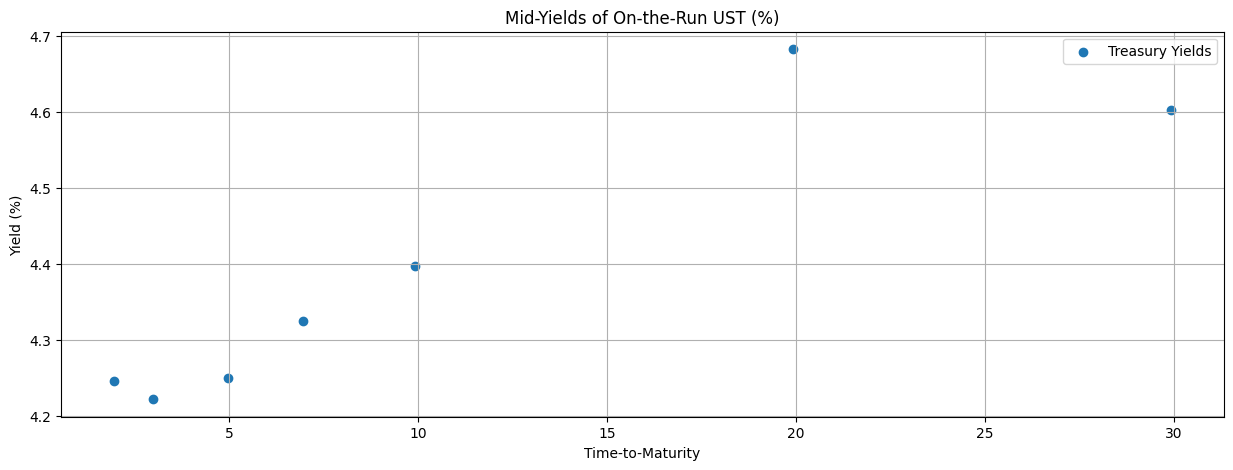

In [15]:
# Input for Scatter Plot
x_values = df_otr_treasuries_all[['TTM']].values
y_values = df_otr_treasuries_all[['midYield']].values

plt.figure(figsize=(15, 5))
plt.scatter(x_values, y_values, label='Treasury Yields')

# Labels and title
plt.xlabel("Time-to-Maturity")
plt.ylabel("Yield (%)")
plt.title("Mid-Yields of On-the-Run UST (%)")
plt.legend()
plt.grid(True)

## b. Calibrate the on-the-run treasury yield curve (bootstrapping)
The function below shows how to calibrate a smooth yield/discount factor curve from the on-the-run treasury dataframe. 

Calibrate the bid, ask and mid discount factor curves as of 2024-12-13.

Display the calibration results for the mid curve, using get_yield_curve_details_df().

In [16]:
def calibrate_yield_curve_from_frame(
        calc_date: ql.Date,
        treasury_details: pd.DataFrame,
        price_quote_column: str):
    '''Create a calibrated yield curve from a details dataframe which includes bid/ask/mid price quotes.
    '''
    ql.Settings.instance().evaluationDate = calc_date

    # Sort dataframe by maturity
    sorted_details_frame = treasury_details.sort_values(by='maturity')    
    
    # For US Treasuries use ql.ActualActual(ql.ActualActual.ISMA)
    day_count = ql.ActualActual(ql.ActualActual.ISMA)

    bond_helpers = []
    
    for index, row in sorted_details_frame.iterrows():
        bond_object = create_bond_from_symbology(row)
        
        tsy_clean_price_quote = row[price_quote_column]
        tsy_clean_price_handle = ql.QuoteHandle(ql.SimpleQuote(tsy_clean_price_quote))
        
        bond_helper = ql.BondHelper(tsy_clean_price_handle, bond_object)
        bond_helpers.append(bond_helper)
        
    yield_curve = ql.PiecewiseLogCubicDiscount(calc_date, bond_helpers, day_count)
    # yield_curve = ql.PiecewiseFlatForward(calc_date, bond_helpers, day_count)
    
    yield_curve.enableExtrapolation()
    return yield_curve


def get_yield_curve_details_df(yield_curve, curve_dates=None):
    
    if(curve_dates == None):
        curve_dates = yield_curve.dates()

    dates = [d.to_date() for d in curve_dates]
    discounts = [round(yield_curve.discount(d), 3) for d in curve_dates]
    yearfracs = [round(yield_curve.timeFromReference(d), 3) for d in curve_dates]
    zeroRates = [round(yield_curve.zeroRate(d, yield_curve.dayCounter(), ql.Compounded).rate() * 100, 3) for d in curve_dates]

    yield_curve_details_df = pd.DataFrame(data={'Date': dates,
                             'YearFrac': yearfracs,
                             'DiscountFactor': discounts,
                             'ZeroRate': zeroRates})                             
    return yield_curve_details_df

In [17]:
# Using bid price

calc_date = calc_date
print(f"Today's date: {calc_date}")

# Dataframe that must contain: maturity, start_date, coupon, days_settle, dcc, 
# Must also contain a column for price (can be determined later)
treasury_details = df_otr_treasuries_all
price_quote_column = 'bidPrice'
print(f"Price Used: {price_quote_column}")

# Yield Curve
yield_curve = calibrate_yield_curve_from_frame(calc_date, treasury_details, price_quote_column)
# Yield Curve Details Dataframe
yield_curve_details_df = get_yield_curve_details_df(yield_curve, curve_dates=None)
display(yield_curve_details_df)

Today's date: December 13th, 2024
Price Used: bidPrice


,Date,YearFrac,DiscountFactor,ZeroRate
0,2024-12-13,0.000,1.000,4.130
1,2026-11-30,2.000,0.921,4.214
2,2027-12-15,3.000,0.882,4.280
3,2029-11-30,5.000,0.812,4.264
4,2031-11-30,7.000,0.742,4.358
5,2034-11-15,9.917,0.648,4.476
6,2044-11-15,19.917,0.390,4.840
7,2054-11-15,29.917,0.256,4.655


In [18]:
# Using ask price

calc_date = calc_date
print(f"Today's date: {calc_date}")

# Dataframe that must contain: maturity, start_date, coupon, days_settle, dcc, 
# Must also contain a column for price (can be determined later)
treasury_details = df_otr_treasuries_all
price_quote_column = 'askPrice'
print(f"Price Used: {price_quote_column}")

# Yield Curve
yield_curve = calibrate_yield_curve_from_frame(calc_date, treasury_details, price_quote_column)
# Yield Curve Details Dataframe
yield_curve_details_df = get_yield_curve_details_df(yield_curve, curve_dates=None)
display(yield_curve_details_df)

Today's date: December 13th, 2024
Price Used: askPrice


,Date,YearFrac,DiscountFactor,ZeroRate
0,2024-12-13,0.000,1.000,4.124
1,2026-11-30,2.000,0.921,4.210
2,2027-12-15,3.000,0.882,4.278
3,2029-11-30,5.000,0.812,4.262
4,2031-11-30,7.000,0.742,4.356
5,2034-11-15,9.917,0.648,4.474
6,2044-11-15,19.917,0.390,4.837
7,2054-11-15,29.917,0.256,4.653


In [19]:
# Using mid price

calc_date = calc_date
print(f"Today's date: {calc_date}")

# Dataframe that must contain: maturity, start_date, coupon, days_settle, dcc, 
# Must also contain a column for price (can be determined later)
treasury_details = df_otr_treasuries_all
price_quote_column = 'midPrice'
print(f"Price Used: {price_quote_column}")

# Yield Curve
tsy_yield_curve_mid = calibrate_yield_curve_from_frame(calc_date, treasury_details, price_quote_column)

# Yield Curve Details Dataframe
yield_curve = tsy_yield_curve_mid
tsy_yield_curve_mid_details = get_yield_curve_details_df(yield_curve, curve_dates=None)
display(tsy_yield_curve_mid_details)

Today's date: December 13th, 2024
Price Used: midPrice


,Date,YearFrac,DiscountFactor,ZeroRate
0,2024-12-13,0.000,1.000,4.127
1,2026-11-30,2.000,0.921,4.212
2,2027-12-15,3.000,0.882,4.279
3,2029-11-30,5.000,0.812,4.263
4,2031-11-30,7.000,0.742,4.357
5,2034-11-15,9.917,0.648,4.475
6,2044-11-15,19.917,0.390,4.839
7,2054-11-15,29.917,0.256,4.654


## c. Plot the calibrated US Treasury yield (zero rate) curves

Create a graph/scatter plot of the newly computed mid yields by maturity.

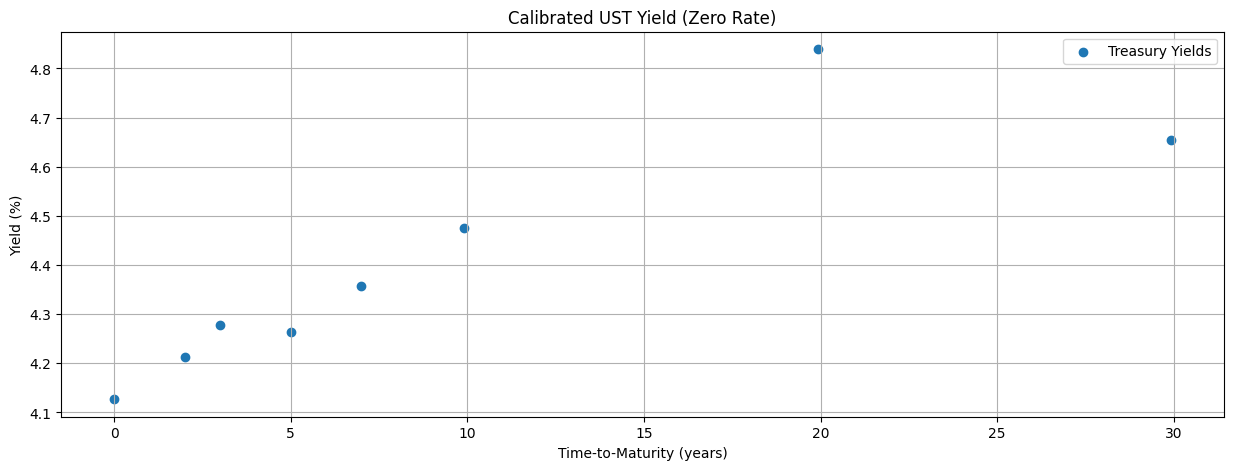

In [20]:
# Input for Scatter Plot
x_values = tsy_yield_curve_mid_details[['YearFrac']].values
y_values = tsy_yield_curve_mid_details[['ZeroRate']].values

plt.figure(figsize=(15, 5))
plt.scatter(x_values, y_values, label='Treasury Yields')

# Labels and title
plt.xlabel("Time-to-Maturity (years)")
plt.ylabel("Yield (%)")
plt.title("Calibrated UST Yield (Zero Rate)")
plt.legend()
plt.grid(True)

## d. Plot calibrated discount factors

Plot the discount factor curve up to the 30 years point, using a 6 months discretization grid.

In [21]:
# Grid Dates for 30 years (y) and the interval is 1 year apart
grid_dates = [yield_curve.referenceDate() + ql.Period(y, ql.Years) for y in list(range(0, 31, 1))]

# Grid Dates for 30 years (but in months --> m), and each interval is 6 months
grid_dates = [yield_curve.referenceDate() + ql.Period(m, ql.Months) for m in range(0, 30 * 12 + 1, 6)]

# Yield Curve Details Dataframe
yield_curve = tsy_yield_curve_mid
tsy_yield_curve_mid_details_extended = get_yield_curve_details_df(yield_curve, grid_dates)     
display(tsy_yield_curve_mid_details_extended)

,Date,YearFrac,DiscountFactor,ZeroRate
0,2024-12-13,0.0,1.000,4.127
1,2025-06-13,0.5,0.980,4.132
2,2025-12-13,1.0,0.960,4.148
3,2026-06-13,1.5,0.940,4.175
4,2026-12-13,2.0,0.921,4.212
...,...,...,...,...
56,2052-12-13,28.0,0.276,4.699
57,2053-06-13,28.5,0.271,4.687
58,2053-12-13,29.0,0.266,4.675
59,2054-06-13,29.5,0.261,4.664


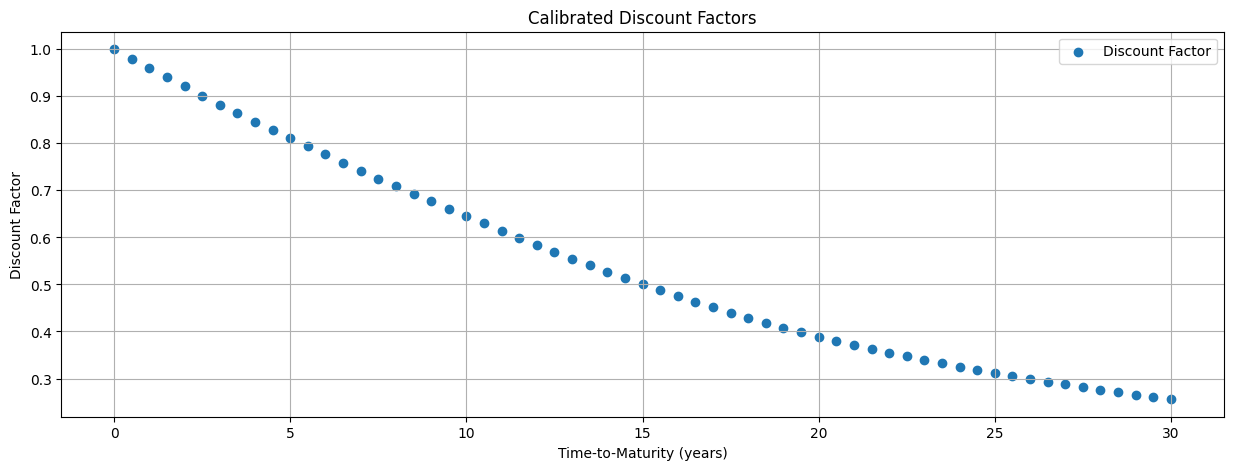

In [22]:
# Input for Scatter Plot
x_values = tsy_yield_curve_mid_details_extended[['YearFrac']].values
y_values = tsy_yield_curve_mid_details_extended[['DiscountFactor']].values

plt.figure(figsize=(15, 5))
plt.scatter(x_values, y_values, label='Discount Factor')

# Labels and title
plt.xlabel("Time-to-Maturity (years)")
plt.ylabel("Discount Factor")
plt.title("Calibrated Discount Factors")
plt.legend()
plt.grid(True)

------------------------------------------------------------------------------------------
# Problem 3: Pricing and risk metrics for US Treasury bonds

## a. US Treasury pricing on the calibrated discount factor curve

Follow Section 5. "Bond Present Value Calculation (no credit risk)" in the QuantLib Basic notebook to re-price the US on-the-run treasuries using the calibrated discount factor curve. 

You will need to switch the bond_engine to use the new on-the-run treasury yield curve:
bond_engine = ql.DiscountingBondEngine(tsy_yield_curve_mid)

Extend the dataframe with the following computed columns for clean mid prices:


| calc_mid_price |
|---------------|


To validate the calibration, compare the calculated clean mid prices to the original market mid prices.

In [23]:
# Yield Curve to use:
yield_curve = tsy_yield_curve_mid

# Price Engine from the Yield Curve

# Add handle for yield curve
yield_curve_handle = ql.YieldTermStructureHandle(yield_curve)
# Create risk-free discounting engine
bond_engine = ql.DiscountingBondEngine(yield_curve_handle)

In [24]:
# Example for one Treasury (ignore this)

# Row 
row_treasury = symbology[(symbology['security'] == 'T 5 3/8 02/15/31')].iloc[0]
# Bond
bond_treasury = create_bond_from_symbology(row_treasury)
print(bond_treasury)

# Appropriate Bond
fixed_rate_bond = bond_treasury

# fixed_rate_bond PV (price)
fixed_rate_bond.setPricingEngine(bond_engine)
print('Bond Dirty Price (= adjusted NPV) = ', round(fixed_rate_bond.dirtyPrice(), 4))
print('Bond Clean Price = ', round(fixed_rate_bond.cleanPrice(), 4))

<QuantLib.QuantLib.FixedRateBond; proxy of <Swig Object of type 'ext::shared_ptr< FixedRateBond > *' at 0x13e3d9600> >
Bond Dirty Price (= adjusted NPV) =  107.8148
Bond Clean Price =  106.0182


In [25]:
# Yield curve to use
yield_curve = tsy_yield_curve_mid
# Add handle for yield curve
yield_curve_handle = ql.YieldTermStructureHandle(yield_curve)
# Create risk-free discounting engine
bond_engine = ql.DiscountingBondEngine(yield_curve_handle)

prices = []
dt_to_iterate = df_otr_treasuries_all

# Apply this to the dataframe of On-th-Run Treasuries
for index, row in dt_to_iterate.iterrows():
    # Bond
    bond = create_bond_from_symbology(row)
    bond.setPricingEngine(bond_engine)
    
    clean_price = bond.cleanPrice()
    #dirty_price = bond.dirtyPrice()
    
    prices.append({
        'isin': row['isin'],
        'calc_mid_price': clean_price,
        #'Dirty Price': dirty_price
    })

# MidPrice using Pricing Engine
df_prices_treasuries_1 = pd.DataFrame(prices)
display(df_prices_treasuries_1)

,isin,calc_mid_price
0,US91282CMB45,99.37890
1,US91282CLY56,100.00390
2,US91282CMA61,99.44140
3,US91282CLZ22,98.80470
4,US91282CLW90,98.82030
5,US912810UE63,98.34375
6,US912810UF39,99.26565


In [26]:
# Merging the original dataframe with the new calculated mid price
df_otr_treasuries_all_2 = pd.merge(df_otr_treasuries_all, df_prices_treasuries_1, on=['isin'], how='inner')

# Difference = Calculated Clean Mid Price - Original Mid Price
df_otr_treasuries_all_2['Price_Diff'] = df_otr_treasuries_all_2['calc_mid_price'] - df_otr_treasuries_all_2['midPrice']

# Relevant columns
df_otr_treasuries_filtered_2 = df_otr_treasuries_all_2[['isin', 'midPrice', 'calc_mid_price', 'Price_Diff']]
display(df_otr_treasuries_filtered_2)

# Mean Absolute Difference
mae = df_otr_treasuries_all_2['Price_Diff'].abs().mean()
mae = round(mae, 4)
print(f"Mean Absolute Difference between the 2 Mid Price Columns: {mae}")

,isin,midPrice,calc_mid_price,Price_Diff
0,US91282CMB45,99.37890,99.37890,9.379164e-13
1,US91282CLY56,100.00390,100.00390,2.515321e-12
2,US91282CMA61,99.44140,99.44140,2.555112e-11
3,US91282CLZ22,98.80470,98.80470,-1.305978e-11
4,US91282CLW90,98.82030,98.82030,1.236344e-12
5,US912810UE63,98.34375,98.34375,7.858603e-12
6,US912810UF39,99.26565,99.26565,-4.438050e-11


Mean Absolute Difference between the 2 Mid Price Columns: 0.0


There is no significant difference between the calculated clean mid prices to the original market mid prices. Calibration is validated.

## b. Compute analytical DV01, Duration and Convexity for US on-the-run treasuries (using flat yield)

Compute analytical DV01, Duration and Convexity metrics, as described in Section 7. "Analytics Duration, Convexity and Z-Spread (flat yield model)" in the QuantLib Basic notebook.

Remember that DV01 = Dirty_Price * Duration. 

Extend the dataframe with the following calculated risk metrics:


| dv01 | duration | convexity |
|-------|-------|-------------|


In [27]:
# Yield curve to use
yield_curve = tsy_yield_curve_mid
# Add handle for yield curve
yield_curve_handle = ql.YieldTermStructureHandle(yield_curve)
# Create risk-free discounting engine
bond_engine = ql.DiscountingBondEngine(yield_curve_handle)

prices = []
dt_to_iterate = df_otr_treasuries_all

# Apply this to the dataframe of On-th-Run Treasuries
for index, row in dt_to_iterate.iterrows():
    # Bond
    bond = create_bond_from_symbology(row)
    bond.setPricingEngine(bond_engine)
    
    clean_price = bond.cleanPrice()
    dirty_price = bond.dirtyPrice()
    
    # For US Treasuries use ql.ActualActual(ql.ActualActual.ISMA)
    # For US Corporate bonds use ql.Thirty360(ql.Thirty360.USA)
    day_count = ql.ActualActual(ql.ActualActual.ISMA)

    flat_bond_yield = row['midYield'] * 1e-2 # in pct
    compounding = ql.Compounded
    coupon_freq = ql.Semiannual

    # Bond Yield Rate, use the flat bond yield
    bond_yield_rate = ql.InterestRate(flat_bond_yield, day_count, compounding, coupon_freq)
    
    bond_duration = ql.BondFunctions.duration(bond, bond_yield_rate)
    bond_convexity = ql.BondFunctions.convexity(bond, bond_yield_rate)
    dv01 = dirty_price * bond_duration / 100
    
    prices.append({
        'isin': row['isin'],
        #'calc_mid_price': clean_price,
        #'Dirty Price': dirty_price,
        'DV01': dv01,
        'Duration': bond_duration,
        'Convexity': bond_convexity,
    })

# MidPrice using Pricing Engine
df_prices_treasuries_2 = pd.DataFrame(prices)
display(df_prices_treasuries_2)

,isin,DV01,Duration,Convexity
0,US91282CMB45,2.777402,2.794451,9.412534
1,US91282CLY56,1.858629,1.855091,4.415195
2,US91282CMA61,4.412674,4.429385,22.942927
3,US91282CLZ22,5.910952,5.971501,41.654301
4,US91282CLW90,7.910886,7.975950,75.888085
5,US912810UE63,15.966515,16.172044,377.793785
6,US912810UF39,12.799454,12.842899,218.617062


In [28]:
# Merging the original dataframe 
df_otr_treasuries_all_3 = pd.merge(df_otr_treasuries_all_2, df_prices_treasuries_2, on=['isin'], how='inner')

# Relevant columns
df_otr_treasuries_filtered_3 = df_otr_treasuries_all_3[['isin','midPrice', 'calc_mid_price', 'Price_Diff',
                                                        'DV01', 'Duration', 'Convexity'
                                                        ]]
display(df_otr_treasuries_filtered_3)


,isin,midPrice,calc_mid_price,Price_Diff,DV01,Duration,Convexity
0,US91282CMB45,99.37890,99.37890,9.379164e-13,2.777402,2.794451,9.412534
1,US91282CLY56,100.00390,100.00390,2.515321e-12,1.858629,1.855091,4.415195
2,US91282CMA61,99.44140,99.44140,2.555112e-11,4.412674,4.429385,22.942927
3,US91282CLZ22,98.80470,98.80470,-1.305978e-11,5.910952,5.971501,41.654301
4,US91282CLW90,98.82030,98.82030,1.236344e-12,7.910886,7.975950,75.888085
5,US912810UE63,98.34375,98.34375,7.858603e-12,15.966515,16.172044,377.793785
6,US912810UF39,99.26565,99.26565,-4.438050e-11,12.799454,12.842899,218.617062


## c. Compute scenario DV01, Duration and Convexity for US on-the-run treasuries (using calibrated yield curve)

Compute the scenario DV01, Duration and Convexity metrics using +/-1bp interest rate shocks, as described in Section 6. "Market Data Scenarios" in the QuantLib Basic notebook.

Remember that DV01 = Dirty_Price * Duration.

Extend the dataframe with the following scenario sensitivities metrics:

| scen_dv01 | scen_duration | scen_convexity |
|-------|-------|-------------|



In [29]:
# Yield curve to use
yield_curve = tsy_yield_curve_mid
# Add handle for yield curve
yield_curve_handle = ql.YieldTermStructureHandle(yield_curve)
# Create risk-free discounting engine
bond_engine = ql.DiscountingBondEngine(yield_curve_handle)

prices = []

# Apply this to the dataframe of On-the-Run Treasuries
for index, row in df_otr_treasuries_all.iterrows():
    # Bond
    bond = create_bond_from_symbology(row)
    
    # Start with base case: interest_rate_bump = 0
    interest_rate_bump = ql.SimpleQuote(0.0)
    yield_curve_bumped = ql.ZeroSpreadedTermStructure(yield_curve_handle, ql.QuoteHandle(interest_rate_bump))

    # Create risk-free discounting engine for base + parallel shift scenarios
    bond_engine_scen = ql.DiscountingBondEngine(ql.YieldTermStructureHandle(yield_curve_bumped))
    bond.setPricingEngine(bond_engine_scen)
        
    price_base = bond.cleanPrice()
    
    # Bump interest rate by +1bps (parallel shift)
    interest_rate_bump.setValue(0.0001)
    price_up_1bp = bond.cleanPrice()

    # Bump interest rate by -1bps (parallel shift)
    interest_rate_bump.setValue(-0.0001)
    price_down_1bp = bond.cleanPrice()
    
    # Reset interest rate bump
    interest_rate_bump.setValue(0)

    # Compute dirty price in base senario
    dirty_price_base = bond.dirtyPrice()

    # Compute scenario delta/gamma sensitivities
    scen_dv01 = round((price_down_1bp - price_base) * 1e4 / 100, 4)
    scen_duration = round(scen_dv01 / dirty_price_base * 100, 4)
    gamma_1bp = (price_down_1bp - 2*price_base + price_up_1bp) * 1e8 / 100
    scen_convexity = round(gamma_1bp / dirty_price_base * 100, 4)

    prices.append({
        'isin': row['isin'],
        'price_base': price_base,
        'price_up_1bp': price_up_1bp,
        'price_down_1bp': price_down_1bp,
        'scen_dv01': scen_dv01,
        'scen_duration': scen_duration,
        'scen_convexity': scen_convexity,
    })

# MidPrice using Pricing Engine
df_prices_treasuries_3 = pd.DataFrame(prices)
display(df_prices_treasuries_3)

,isin,price_base,price_up_1bp,price_down_1bp,scen_dv01,scen_duration,scen_convexity
0,US91282CMB45,99.37890,99.350600,99.407208,2.8308,2.8482,8.3556
1,US91282CLY56,100.00390,99.984563,100.023241,1.9341,1.9304,3.7942
2,US91282CMA61,99.44140,99.395989,99.486833,4.5433,4.5605,21.9925
3,US91282CLZ22,98.80470,98.743990,98.865451,6.0751,6.1373,40.8507
4,US91282CLW90,98.82030,98.739636,98.901038,8.0738,8.1402,74.9672
5,US912810UE63,98.34375,98.181525,98.506355,16.2605,16.4698,384.4929
6,US912810UF39,99.26565,99.135901,99.395618,12.9968,13.0409,219.4308


In [30]:
# Merging the original dataframe 
df_otr_treasuries_all_4 = pd.merge(df_otr_treasuries_all_3, df_prices_treasuries_3, on=['isin'], how='inner')

# Relevant columns
df_otr_treasuries_filtered_4 = df_otr_treasuries_all_4[['isin', 'midPrice', 'calc_mid_price', 'Price_Diff',
                                                        'DV01', 'Duration', 'Convexity', 'scen_dv01', 'scen_duration', 'scen_convexity'
                                                        ]]
display(df_otr_treasuries_filtered_4)

,isin,midPrice,calc_mid_price,Price_Diff,DV01,Duration,Convexity,scen_dv01,scen_duration,scen_convexity
0,US91282CMB45,99.37890,99.37890,9.379164e-13,2.777402,2.794451,9.412534,2.8308,2.8482,8.3556
1,US91282CLY56,100.00390,100.00390,2.515321e-12,1.858629,1.855091,4.415195,1.9341,1.9304,3.7942
2,US91282CMA61,99.44140,99.44140,2.555112e-11,4.412674,4.429385,22.942927,4.5433,4.5605,21.9925
3,US91282CLZ22,98.80470,98.80470,-1.305978e-11,5.910952,5.971501,41.654301,6.0751,6.1373,40.8507
4,US91282CLW90,98.82030,98.82030,1.236344e-12,7.910886,7.975950,75.888085,8.0738,8.1402,74.9672
5,US912810UE63,98.34375,98.34375,7.858603e-12,15.966515,16.172044,377.793785,16.2605,16.4698,384.4929
6,US912810UF39,99.26565,99.26565,-4.438050e-11,12.799454,12.842899,218.617062,12.9968,13.0409,219.4308


------------------------------------------------------------------------------------------
# Problem 4: Pricing and risk metrics for corporate bonds

## a. Create the fixed-rate corporate bond objects

Restrict the symbology dataframe to fixed rate corporate bonds only and create the corporate bond objects. 

Display the future cashflows for the `AAPL 2.2 09/11/29` bond.

In [31]:
# Bond Symbology Dataframe = Containing both corporate and US Government Bonds
filepath_rawdata = f'./data/bond_symbology.xlsx'
bond_symbology = pd.read_excel(filepath_rawdata)
days_in_year = 365.25
date_today = pd.to_datetime('2024-12-13')
bond_symbology['term'] = ((bond_symbology['maturity']) - bond_symbology['start_date']).dt.days /days_in_year
bond_symbology['TTM'] = ((bond_symbology['maturity'] - date_today)).dt.days /days_in_year
# If TTM is less than or equal to 0, then it's 0
bond_symbology.loc[bond_symbology['TTM'] <= 0, 'TTM'] = 0

# Symbology Corp = Corporate Bond Dataframe
symbology_corp = bond_symbology[(bond_symbology['class'] == 'Corp') & 
                      (bond_symbology['cpn_type'] == 'FIXED')
                      ]
symbology_corp.head(3)

,ticker,class,figi,isin,und_bench_isin,security,name,type,coupon,cpn_type,...,acc_first,maturity,mty_typ,rank,amt_out,country,currency,status,term,TTM
0,AAPL,Corp,BBG004HST0K7,US037833AL42,US912810UF39,AAPL 3.85 05/04/43,APPLE INC,GLOBAL,3.85,FIXED,...,2013-05-03,2043-05-04,AT MATURITY,Sr Unsecured,3000.0,US,USD,ACTV,30.001369,18.387406
1,AAPL,Corp,BBG006F8VWJ7,US037833AT77,US912810UF39,AAPL 4.45 05/06/44,APPLE INC,GLOBAL,4.45,FIXED,...,2014-05-06,2044-05-06,AT MATURITY,Sr Unsecured,1000.0,US,USD,ACTV,30.001369,19.394935
2,AAPL,Corp,BBG0081TNL50,US037833BA77,US912810UF39,AAPL 3.45 02/09/45,APPLE INC,GLOBAL,3.45,FIXED,...,2015-02-09,2045-02-09,AT MATURITY,Sr Unsecured,2000.0,US,USD,ACTV,30.001369,20.158795


In [32]:
# Row from Symbology Dataframe
df_apple = symbology[(symbology['security'] == 'AAPL 2.2 09/11/29')]
df_apple

,ticker,class,figi,isin,und_bench_isin,security,name,type,coupon,cpn_type,...,start_date,cpn_first,acc_first,maturity,mty_typ,rank,amt_out,country,currency,status
18,AAPL,Corp,BBG00Q5L6G53,US037833DP29,US91282CMA61,AAPL 2.2 09/11/29,APPLE INC,GLOBAL,2.2,FIXED,...,2019-09-11,2020-03-11,2019-09-11,2029-09-11,CALLABLE,Sr Unsecured,1750.0,US,USD,ACTV


In [33]:
# AAPL 2.2 09/11/29

# Row from Symbology Dataframe
row_apple = symbology[(symbology['security'] == 'AAPL 2.2 09/11/29')].iloc[0]

# Bond
bond_apple = create_bond_from_symbology(row_apple)
# print(bond_apple)

# Today's Date
# print(f"Today's date: {calc_date}")

# Security Name
name_treasury = row_apple['security']
print(f"Security: {name_treasury}")

# Cash Flow
df_cashflow_apple = get_bond_cashflows(bond_apple, calc_date)
display(df_cashflow_apple)

Security: AAPL 2.2 09/11/29


,CashFlowDate,CashFlowAmount,CashFlowYearFraction
0,"March 11th, 2025",1.1,0.244444
1,"September 11th, 2025",1.1,0.744444
2,"March 11th, 2026",1.1,1.244444
3,"September 11th, 2026",1.1,1.744444
4,"March 11th, 2027",1.1,2.244444
5,"September 11th, 2027",1.1,2.744444
6,"March 11th, 2028",1.1,3.244444
7,"September 11th, 2028",1.1,3.744444
8,"March 11th, 2029",1.1,4.244444
9,"September 11th, 2029",1.1,4.744444


## b. Compute analytical Yields and Z-Spreads

Compute analytical Yields and Z-Spreads metrics, as described in Section 7. "Analytical Duration, Convexity and Z-Spread (flat yield model)" in the QuantLib Basic notebook.

Extend the dataframe with the following calculated risk metrics:


| calc_yield | calc_zspread |
|-------|-------------|


In [34]:
# Corporate Symbology + Market
df_merged_corp_symbo_market = pd.merge(data_market, symbology_corp, on=['isin', 'class', 'figi', 'ticker'], how='inner')
df_merged_corp_symbo_market.head()

,date,class,ticker,isin,figi,bidPrice,askPrice,accrued,bidYield,askYield,...,acc_first,maturity,mty_typ,rank,amt_out,country,currency,status,term,TTM
0,2024-12-13,Corp,AAPL,US037833BX70,BBG00C7QBG91,93.228,93.809,1.4595,5.180,5.132,...,2016-02-23,2046-02-23,CALLABLE,Sr Unsecured,4000.0,US,USD,ACTV,30.001369,21.196441
1,2024-12-13,Corp,AAPL,US037833EK23,BBG011ZS1X57,63.723,64.232,0.9835,5.242,5.194,...,2021-08-05,2051-08-05,CALLABLE,Sr Unsecured,1800.0,US,USD,ACTV,29.998631,26.642026
2,2024-12-13,Corp,AAPL,US037833DW79,BBG00TN2PN26,63.716,64.215,0.2585,5.253,5.205,...,2020-05-11,2050-05-11,CALLABLE,Sr Unsecured,2500.0,US,USD,ACTV,29.998631,25.407255
3,2024-12-13,Corp,AAPL,US037833EF38,BBG00Z3VQ626,63.262,63.766,0.9420,5.249,5.200,...,2021-02-08,2051-02-08,CALLABLE,Sr Unsecured,3000.0,US,USD,ACTV,29.998631,26.154689
4,2024-12-13,Corp,AAPL,US037833CD08,BBG00DHQX9M5,82.278,82.848,1.4120,5.227,5.177,...,2016-08-04,2046-08-04,CALLABLE,Sr Unsecured,2000.0,US,USD,ACTV,29.998631,21.639973


In [ ]:
# Yield Curve to use (be careful!)
yield_curve = tsy_yield_curve_mid
# Add handle for yield curve
yield_curve_handle = ql.YieldTermStructureHandle(yield_curve)
# Create a Discount Factor from the Yield Curve
bond_engine = ql.DiscountingBondEngine(yield_curve_handle)

# Set yield conventions
compounding = ql.Compounded
coupon_freq = ql.Semiannual
day_count
# Apply this to the corporate dataframe merged with market data
prices = []

# Apply to the appropriate dataframe
for index, row in df_merged_corp_symbo_market.iterrows():
    # Bond
    bond = create_bond_from_symbology(row)
    
    # Apply the bond engine to the bond in question
    bond.setPricingEngine(bond_engine)
    bond_market_price = bond.cleanPrice() # Clean market price, implies zero Z-Spread!
    
    settle_date = bond.settlementDate(calc_date)
    bond_yield = bond.bondYield(bond_market_price, bond.dayCounter(), compounding, coupon_freq, settle_date) * 100 # In percent

    # Use the Mid Price
    bond_test_price = row['midPrice'] # Test market price, implies Z-Spread > 0
    
    # Z-Spread using the Test Price
    # Use the Treasury yield curve because the Z-spread is above the risk-free rate
    zspread = ql.BondFunctions.zSpread(bond, bond_test_price, yield_curve, day_count, compounding, coupon_freq)

    prices.append({
        'security': row['security'],
        'Test Price': bond_test_price,
        'calc_yield': bond_yield,
        'calc_zspread': zspread
    })

df_prices_corp_1 = pd.DataFrame(prices)
display(df_prices_corp_1)


,security,Test Price,calc_yield,calc_zspread
0,AAPL 4.65 02/23/46,93.5185,4.686357,0.004739
1,AAPL 2.7 08/05/51,63.9775,4.655834,0.005647
2,AAPL 2.65 05/11/50,63.9655,4.670079,0.005626
3,AAPL 2.65 02/08/51,63.5140,4.661359,0.005661
4,AAPL 3.85 08/04/46,82.5630,4.701713,0.005032
...,...,...,...,...
130,ORCL 3 1/4 11/15/27,96.2925,4.221096,0.004034
131,ORCL 3 1/4 05/15/30,92.2565,4.224536,0.006712
132,ORCL 2.95 04/01/30,91.0550,4.255609,0.006279
133,ORCL 1.65 03/25/26,96.2605,4.008515,0.007149


In [36]:
# Merging the original dataframe 
df_merged_corp_symbo_market_2 = pd.merge(df_merged_corp_symbo_market, df_prices_corp_1, on=['security'], how='inner')

# Relevant columns
df_merged_corp_symbo_market_2_filtered = df_merged_corp_symbo_market_2[['security', 'midPrice', 'Test Price',
                                                                        'calc_yield', 'calc_zspread']]
display(df_merged_corp_symbo_market_2_filtered)

,security,midPrice,Test Price,calc_yield,calc_zspread
0,AAPL 4.65 02/23/46,93.5185,93.5185,4.686357,0.004739
1,AAPL 2.7 08/05/51,63.9775,63.9775,4.655834,0.005647
2,AAPL 2.65 05/11/50,63.9655,63.9655,4.670079,0.005626
3,AAPL 2.65 02/08/51,63.5140,63.5140,4.661359,0.005661
4,AAPL 3.85 08/04/46,82.5630,82.5630,4.701713,0.005032
...,...,...,...,...,...
130,ORCL 3 1/4 11/15/27,96.2925,96.2925,4.221096,0.004034
131,ORCL 3 1/4 05/15/30,92.2565,92.2565,4.224536,0.006712
132,ORCL 2.95 04/01/30,91.0550,91.0550,4.255609,0.006279
133,ORCL 1.65 03/25/26,96.2605,96.2605,4.008515,0.007149


## c. Validate Z-Spread computation for a few fixed rate corporate bonds

For the following corporate bonds:

* `IBM 1.95 05/15/30`
* `ORCL 2 7/8 03/25/31`
* `DIS 6.65 11/15/37`

use function below to re-price them using the calibrated flat z-spread. Follow the example in Section 7. "Analytical Duration, Convexity and Z-Spread (flat yield model)".

Validate/confirm that you match the original market prices, which were used as input to the z-Spread function.


In [37]:
def calc_clean_price_with_zspread(fixed_rate_bond, yield_curve_handle, zspread):
    zspread_quote = ql.SimpleQuote(zspread)
    zspread_quote_handle = ql.QuoteHandle(zspread_quote)
    yield_curve_bumped = ql.ZeroSpreadedTermStructure(yield_curve_handle, zspread_quote_handle, ql.Compounded, ql.Semiannual)
    yield_curve_bumped_handle = ql.YieldTermStructureHandle(yield_curve_bumped)
    
    # Set Valuation engine
    bond_engine = ql.DiscountingBondEngine(yield_curve_bumped_handle)
    fixed_rate_bond.setPricingEngine(bond_engine)
    bond_clean_price = fixed_rate_bond.cleanPrice()
    return bond_clean_price


In [38]:
# Filter only for those bonds
df_corp_bond_check = df_merged_corp_symbo_market[
    df_merged_corp_symbo_market['security'].isin([
        'IBM 1.95 05/15/30',
        'ORCL 2 7/8 03/25/31',
        'DIS 6.65 11/15/37'
    ])
]
df_corp_bond_check

,date,class,ticker,isin,figi,bidPrice,askPrice,accrued,bidYield,askYield,...,acc_first,maturity,mty_typ,rank,amt_out,country,currency,status,term,TTM
44,2024-12-13,Corp,DIS,US254687EH59,BBG00QNKSBB5,113.141,113.628,0.5735,5.236,5.188,...,2019-11-15,2037-11-15,AT MATURITY,Sr Unsecured,1223.938,US,USD,ACTV,17.982204,12.922656
83,2024-12-13,Corp,IBM,US459200KJ94,BBG00TL9X0X0,86.261,86.609,0.1680,4.867,4.787,...,2020-05-07,2030-05-15,CALLABLE,Sr Unsecured,1350.000,US,USD,ACTV,10.020534,5.418207
118,2024-12-13,Corp,ORCL,US68389XCE31,BBG00ZS0BP85,88.553,88.864,0.6475,5.024,4.961,...,2021-03-24,2031-03-25,CALLABLE,Sr Unsecured,3250.000,US,USD,ACTV,10.001369,6.277892


In [39]:
# Yield Curve to use (be careful!)
yield_curve = tsy_yield_curve_mid
# Add handle for yield curve
yield_curve_handle = ql.YieldTermStructureHandle(yield_curve)
# Create a Discount Factor from the Yield Curve
bond_engine = ql.DiscountingBondEngine(yield_curve_handle)

# Set yield conventions
compounding = ql.Compounded
coupon_freq = ql.Semiannual

# Apply this to the corporate dataframe merged with market data
prices = []

# Go through the appropriate dataframe
for index, row in df_corp_bond_check.iterrows():
    # Bond
    bond = create_bond_from_symbology(row)
    
    # Apply the bond engine to the bond in question
    bond.setPricingEngine(bond_engine)
    bond_market_price = bond.cleanPrice() # Clean market price, implies zero Z-Spread!
    
    settle_date = bond.settlementDate(calc_date)
    bond_yield = bond.bondYield(bond_market_price, bond.dayCounter(), compounding, coupon_freq, settle_date) * 100 # In percent    
    
    # Use the Mid Price
    bond_test_price = row['midPrice'] # Test market price, implies Z-Spread > 0
    
    # Z-Spread using the Test Price
    # Use the Treasury yield curve because the Z-spread is above the risk-free rate
    zspread = ql.BondFunctions.zSpread(bond, bond_test_price, yield_curve, day_count, compounding, coupon_freq)

    # Bond Price with the Z-Spread
    bond_zspread_price = calc_clean_price_with_zspread(bond, yield_curve_handle, zspread)
    
    # Difference between the Z-Spread Computed Price vs the Original
    bond_price_diff = bond_zspread_price - bond_test_price
    
    prices.append({
        'security': row['security'],
        'Test Price': bond_test_price,
        'calc_yield': bond_yield,
        'calc_zspread': zspread,
        'bond_zspread_price': bond_zspread_price,
        'bond_price_diff': bond_price_diff,
    })

df_prices_corp_2 = pd.DataFrame(prices)
display(df_prices_corp_2)

,security,Test Price,calc_yield,calc_zspread,bond_zspread_price,bond_price_diff
0,DIS 6.65 11/15/37,113.3845,4.501195,0.007140,113.3845,1.312273e-09
1,IBM 1.95 05/15/30,86.4350,4.225456,0.006020,86.4350,1.719513e-12
2,ORCL 2 7/8 03/25/31,88.7085,4.242237,0.007548,88.7085,-5.080381e-11


In [40]:
# Mean Absolute Difference
mae = df_prices_corp_2['bond_price_diff'].abs().mean()
mae = round(mae, 4)
print(f"Mean Absolute Difference between the Bond Prices: {mae}")

Mean Absolute Difference between the Bond Prices: 0.0


We have confirmed that the calculated z-spread computed prices match the original market prices, which were used as input to the z-Spread function.

## d. Compute Duration and Convexity for fixed rate corporate bonds (using flat yield)

Compute analytical Duration and Convexity metrics, as described in Section 7. "Analytical Duration, Convexity and Z-Spread (flat yield model)" in the QuantLib Basic notebook.

Extend the dataframe with the following calculated risk metrics:


| calc_duration | calc_convexity |
|-------|-------------|

Display the head of the dataframe.

Scatter plot duration and convexity by TTM for all AAPL (fixed-rate) bonds.

In [41]:
# Yield Curve to use (be careful!)
yield_curve = tsy_yield_curve_mid
# Add handle for yield curve
yield_curve_handle = ql.YieldTermStructureHandle(yield_curve)
# Create a Discount Factor from the Yield Curve
bond_engine = ql.DiscountingBondEngine(yield_curve_handle)

# Set yield conventions
compounding = ql.Compounded
coupon_freq = ql.Semiannual

# Apply this to the corporate dataframe merged with market data
prices = []

# Apply to the appropriate dataframe
for index, row in df_merged_corp_symbo_market.iterrows():
    # Bond
    bond = create_bond_from_symbology(row)
    
    # Apply the bond engine to the bond in question
    bond.setPricingEngine(bond_engine)
    bond_market_price = bond.cleanPrice() # Clean market price, implies zero Z-Spread!
    
    settle_date = bond.settlementDate(calc_date)
    bond_yield = bond.bondYield(bond_market_price, bond.dayCounter(), compounding, coupon_freq, settle_date) * 100 # In percent

    # Use the Mid Price
    bond_test_price = row['midPrice'] # Test market price, implies Z-Spread > 0
    
    # Z-Spread using the Test Price
    # Use the Treasury yield curve because the Z-spread is above the risk-free rate
    bond_zspread_test_price = ql.BondFunctions.zSpread(bond, bond_test_price, yield_curve, day_count, compounding, coupon_freq)

    # Bond Price with the Z-Spread
    bond_zspread_price = calc_clean_price_with_zspread(bond, yield_curve_handle, bond_zspread_test_price)
    
    # Difference between the Z-Spread Computed Price vs the Original
    bond_price_diff = bond_zspread_price - bond_test_price
    
    # Calc Duration and Convexity
    bond_yield = row["midYield"]*1e-2 # Use the Yields given instead
    bond_yield_rate = ql.InterestRate(bond_yield, day_count, compounding, coupon_freq)
    bond_duration = ql.BondFunctions.duration(bond, bond_yield_rate)
    bond_convexity = ql.BondFunctions.convexity(bond, bond_yield_rate)
    
    prices.append({
        'security': row['security'],
        'Test Price': bond_test_price,
        'calc_yield': bond_yield,
        'calc_zspread': bond_zspread_test_price,
        #'bond_zspread_price': bond_zspread_price,
        #'bond_price_diff': bond_price_diff,
        'calc_duration': bond_duration,
        'calc_convexity': bond_convexity
    })

df_prices_corp_3 = pd.DataFrame(prices)
display(df_prices_corp_3.head())

,security,Test Price,calc_yield,calc_zspread,calc_duration,calc_convexity
0,AAPL 4.65 02/23/46,93.5185,0.051560,0.004739,12.881701,228.068551
1,AAPL 2.7 08/05/51,63.9775,0.052180,0.005647,16.287829,365.156642
2,AAPL 2.65 05/11/50,63.9655,0.052290,0.005626,16.148258,349.637066
3,AAPL 2.65 02/08/51,63.5140,0.052245,0.005661,16.212270,358.987301
4,AAPL 3.85 08/04/46,82.5630,0.052020,0.005032,13.516503,248.114798


In [42]:
# Merging the original dataframe 
df_merged_corp_symbo_market_3 = pd.merge(df_merged_corp_symbo_market, df_prices_corp_3, on=['security'], how='inner')

# Relevant columns
df_merged_corp_symbo_market_3_filtered = df_merged_corp_symbo_market_3[['security', 'midPrice', 'Test Price',
                                                                        'calc_yield', 'calc_zspread',
                                                                        'calc_duration', 'calc_convexity']]
display(df_merged_corp_symbo_market_3.head())

,date,class,ticker,isin,figi,bidPrice,askPrice,accrued,bidYield,askYield,...,country,currency,status,term,TTM,Test Price,calc_yield,calc_zspread,calc_duration,calc_convexity
0,2024-12-13,Corp,AAPL,US037833BX70,BBG00C7QBG91,93.228,93.809,1.4595,5.180,5.132,...,US,USD,ACTV,30.001369,21.196441,93.5185,0.051560,0.004739,12.881701,228.068551
1,2024-12-13,Corp,AAPL,US037833EK23,BBG011ZS1X57,63.723,64.232,0.9835,5.242,5.194,...,US,USD,ACTV,29.998631,26.642026,63.9775,0.052180,0.005647,16.287829,365.156642
2,2024-12-13,Corp,AAPL,US037833DW79,BBG00TN2PN26,63.716,64.215,0.2585,5.253,5.205,...,US,USD,ACTV,29.998631,25.407255,63.9655,0.052290,0.005626,16.148258,349.637066
3,2024-12-13,Corp,AAPL,US037833EF38,BBG00Z3VQ626,63.262,63.766,0.9420,5.249,5.200,...,US,USD,ACTV,29.998631,26.154689,63.5140,0.052245,0.005661,16.212270,358.987301
4,2024-12-13,Corp,AAPL,US037833CD08,BBG00DHQX9M5,82.278,82.848,1.4120,5.227,5.177,...,US,USD,ACTV,29.998631,21.639973,82.5630,0.052020,0.005032,13.516503,248.114798


In [43]:
# Dataframe for only Fixed-Rate Apple Bonds
df_apple_2 = df_merged_corp_symbo_market_3[(df_merged_corp_symbo_market_3['ticker'] == 'AAPL') &
                                           (df_merged_corp_symbo_market_3['cpn_type'] == 'FIXED')
                                           ]

# Filter only Relevant Columns
df_apple_2_filtered = df_apple_2[['security', 'TTM', 'calc_duration', 'calc_convexity']]

# Sort by index
df_apple_2_filtered_sorted = df_apple_2_filtered.set_index('TTM').sort_index()
display(df_apple_2_filtered_sorted.head())
display(df_apple_2_filtered_sorted.tail())

,security,calc_duration,calc_convexity
TTM,,,
1.155373,AAPL 0.7 02/08/26,1.116806,1.797930
1.196441,AAPL 3 1/4 02/23/26,1.138448,1.871777
1.399042,AAPL 4.421 05/08/26,1.332867,2.453098
1.639973,AAPL 2.45 08/04/26,1.564827,3.254366
1.744011,AAPL 2.05 09/11/26,1.667277,3.629520


,security,calc_duration,calc_convexity
TTM,,,
28.405202,AAPL 4.85 05/10/53,15.047435,330.608826
35.685147,AAPL 2.55 08/20/60,18.955916,532.881248
36.156057,AAPL 2.8 02/08/61,18.224860,505.875249
36.643395,AAPL 2.85 08/05/61,18.199130,508.133689
37.650924,AAPL 4.1 08/08/62,16.865673,453.575528


In [44]:
# Reset index to ensure 'TTM' is a column, not index
df_plot = df_apple_2_filtered_sorted.reset_index()

fig = px.scatter(df_plot,
                 x='TTM',
                 y='calc_duration',
                 color='security',
                 title='Duration for AAPL (fixed-rate) Bonds',
                 labels={'TTM': 'Time to Maturity (Years)', 'calc_duration': 'Duration (Years)'}
                )

fig.update_layout(
    legend_title_text='Security',
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=1.05,
        bgcolor='rgba(255,255,255,0)',
        bordercolor='black',
        borderwidth=1
    )
)
fig.show()

In [45]:
# Reset index to ensure 'TTM' is a column, not index
df_plot = df_apple_2_filtered_sorted.reset_index()

fig = px.scatter(df_plot,
                 x='TTM',
                 y='calc_convexity',
                 color='security',
                 title='Convexity for AAPL (fixed-rate) Bonds',
                 labels={'TTM': 'Time to Maturity (Years)', 'calc_convexity': 'Convexity'}
                )

fig.update_layout(
    legend_title_text='Security',
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=1.05,
        bgcolor='rgba(255,255,255,0)',
        bordercolor='black',
        borderwidth=1
    )
)
fig.show()